Oseen Equation
===

Import Netgen/NGSolve Python modules:

In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
from math import log
import numpy as np
import scipy.sparse as sp
SetHeapSize(int(1e9))   

In [2]:
1/16

0.0625

In [3]:
N = 1
T = 0.2
tau = T/N 
gamma0 = 1
gamma1 = 1
gamma_dual = 1e-5
gamma_M = 1e5
maxh = 0.6
solver = "pardiso"
#solver = "umfpack"

In [4]:
#maxh

The unit_square is a predefined domain, use Netgen to generate a mesh:

In [5]:
def freedofs_converter(fd):
    frees = [] 
    for i in range(len(fd)):
        if fd[i]:
            frees.append(i)
    return frees

def cond_est(a,frees):
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    A_red = A.todense()[frees,:][:,frees] 
    return np.linalg.cond(A_red)

In [6]:
def GetMeshDataAllAround(maxh):
    geo = SplineGeometry()
    # data domain
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (1,0)
    p4 = geo.AppendPoint (0.75,0.75)
    p5 = geo.AppendPoint (0.75,0.25)
    p6 = geo.AppendPoint (0.25,0.25)
    p7 = geo.AppendPoint (0.25,0.75)
    p11 = geo.AppendPoint(1.0,1.0)
    p12 = geo.AppendPoint(0.0,1.0)
    # omega
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p11], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p11, p12], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p12, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B
    geo.Append (["line", p6, p5], leftdomain=2, rightdomain=1)
    geo.Append (["line", p5, p4], leftdomain=2, rightdomain=1)
    geo.Append (["line", p4, p7], leftdomain=2, rightdomain=1)
    geo.Append (["line", p7, p6], leftdomain=2, rightdomain=1)
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [7]:
def GetMeshDataLeft(maxh):
    geo = SplineGeometry()
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (0.25,0)
    p3 = geo.AppendPoint (0.25,1)
    p4 = geo.AppendPoint (0,1)
    p5 = geo.AppendPoint (1,0)
    p6 = geo.AppendPoint (1,1)
    # omega 
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p3], leftdomain=1, rightdomain=2)
    geo.Append (["line", p3, p4], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p4, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B 
    geo.Append (["line", p2, p5], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p5, p6], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p6, p3], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [8]:
#mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
mesh = Mesh(GetMeshDataAllAround(maxh) )
# mesh = Mesh(GetMeshDataLeft(maxh))
h = specialcf.mesh_size
n = specialcf.normal(2)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [9]:
t = Parameter(0.0)

u_sol = CoefficientFunction( (  2*x**2*y*(2*y-1)*(x-1)**2*(y-1)*exp(-t), 
                            -2*x*y**2*(2*x-1)*(x-1)*(y-1)**2*exp(-t) ) )
p_sol = (2*cos(x)*sin(y) - 2*sin(1)*(1 - cos(1)))*exp(-t) 
#beta = CoefficientFunction( ( 1.0 , 1.0 ) )
beta = CoefficientFunction( ( 0.0 , 0.0 ) )
rhs = CoefficientFunction( ( 2*(-x**2*y*(x - 1)**2*(y - 1)*(2*y - 1) + 6*x**2*(1 - 2*y)*(x - 1)**2 
              - 2*y*(y - 1)*(2*y - 1)*(x**2 + 4*x*(x - 1) + (x - 1)**2) - sin(x)*sin(y)
              + beta[0]*2*(2*y**3 - 3*y**2 + y)*(4*x**3-6*x**2+2*x)
              + beta[1]*2*(6*y**2-6*y+1)*(x**4-2*x**3+x**2) )*exp(-t)  , 
                           2*(x*y**2*(x - 1)*(2*x - 1)*(y - 1)**2 + 2*x*(x - 1)*(2*x - 1)*(y**2 + 4*y*(y - 1) 
                    + (y - 1)**2) + 6*y**2*(2*x - 1)*(y - 1)**2 + cos(x)*cos(y)
                    - beta[0]*2*(6*x**2-6*x+1)*(y**4-2*y**3+y**2)
                    - beta[1]*2*(2*x**3-3*x**2+x)*(4*y**3-6*y**2+2*y))*exp(-t))  )

# u_sol = CoefficientFunction( (   2*cos(t)*sin(pi*x)*sin(pi*x)*y*(1-y)*(1-2*y), 
#                             (-pi)*(cos(t))*sin(2*pi*x)*(y**4-2*y**3+y**2) ) )
# p_sol = sin(pi*x)*cos(pi*y)*cos(t) 
# beta = CoefficientFunction( ( 1.0 , 1.0 ) )
# rhs = CoefficientFunction( ( -2*sin(t)*sin(pi*x)*sin(pi*x)*y*(1-y)*(1-2*y)
#        -4*pi**2*cos(2*pi*x)*cos(t)*(2*y**3-3*y**2+y)-2*sin(pi*x)**2*cos(t)*(12*y-6)+pi*cos(pi*x)*cos(pi*y)*cos(t)  , 
#                            pi*sin(2*pi*x)*(y**4-2*y**3+y**2)*sin(t)
#       -(4*pi**3*sin(2*pi*x)*(y**4-2*y**3+y**2)*cos(t)-pi*sin(2*pi*x)*(12*y**2-12*y+2)*cos(t))
#       -pi*sin(pi*x)*sin(pi*y)*cos(t) )  )



Define a finite element space on that mesh. 

In [10]:
#fes = H1(mesh, order=3, dirichlet="left|right|bottom|top")
fes_NC = FESpace("nonconforming",mesh, dirichlet="bc_Omega", dgjumps = True) 
fes_lam = NumberSpace(mesh)
fes_L2 = L2(mesh, order=0)
fes_primal_vel = FESpace([fes_NC*fes_NC for i in range(N+1) ])
fes_primal_pressure = FESpace([ fes_L2 for i in range(N) ])
fes_dual_vel = FESpace([fes_NC*fes_NC for i in range(N) ])
fes_dual_pressure = FESpace([ fes_L2 for i in range(N) ])
fes_primal_lam = FESpace([fes_lam for i in range(N)])
fes_dual_lam = FESpace([fes_lam for i in range(N)])
X = FESpace( [fes_primal_vel, fes_primal_pressure,fes_primal_lam, fes_dual_vel, fes_dual_pressure,fes_dual_lam])
print ("X-ndof = {0}".format(X.ndof ))

X-ndof = 180


In [11]:
#gfu = GridFunction(X)
#Draw( gfu.components[0].components[N].components[1], mesh)
#print(gfu.components[0].dim)
#help(gfu)
#help(gfu.components[1])
#print(gfu.components[0][0].FV().NumPy())
#print(gfu.components[0][0].dim)
#help( gfu.components[0][0])
#print(len(gfu.components[0][0] ))
#Draw(gfu.components[1],mesh )

In [12]:
#help(gfu.components[0].components[0].components[0])

In [13]:
len(X.TrialFunction()) 

6

In [14]:
u, pp, llam, zz, yyy, xxi =  X.TrialFunction()
v, qq, mmu, ww, xxx, eeta =  X.TestFunction()
#print(len(u[0]) )
#print

p = [None] + [pp[i] for i in range(len(pp)) ]
z = [None] + [zz[i] for i in range(len(zz)) ]
yy = [None] + [yyy[i] for i in range(len(yyy)) ]
lam = [None] + [llam[i] for i in range(len(llam)) ]
xi = [None] + [xxi[i] for i in range(len(xxi)) ]

q = [None] + [qq[i] for i in range(len(qq)) ]
w = [None] + [ww[i] for i in range(len(ww)) ]
xx = [None] + [xxx[i] for i in range(len(xxx)) ]
mu = [None] + [mmu[i] for i in range(len(mmu)) ]
eta = [None] + [eeta[i] for i in range(len(eeta)) ]

#help(xx)

In [15]:
def IP(u,v,nabla=False):
    if nabla:
        return sum( [ grad(u[i])*grad(v[i]) for i in range(len(u))] )
    else:
        return sum( [u[i]*v[i] for i in range(len(u))] )

def IP_conv(u,v):
    return beta[0]*grad(u[0])[0]*v[0]+beta[1]*grad(u[0])[1]*v[0]+beta[0]*grad(u[1])[0]*v[1]+beta[1]*grad(u[1])[1]*v[1]
    
def IP_ut_v(u_cur,u_prev,v):
    return sum( [ (u_cur[i] - u_prev[i] ) * v[i] for i in range(len(u_cur))] )
    #help(IP(u[0],v[0]))
def IP_mixed_stab(u_cur,u_prev,v_cur,v_prev):
    return sum( [ ( grad(u_cur[i]) - grad(u_prev[i]) ) * ( grad(v_cur[i]) - grad(v_prev[i]) )  for i in range(len(u_cur))] )

def IP_CIP(u,v):
    return sum( [ (u[i] - u[i].Other()) * (v[i] - v[i].Other()) for i in range(len(u))  ] )

def IP_jump_avg(u,v):
    return sum( [ (u[i] - u[i].Other()) * 0.5 * (v[i] + v[i].Other()) for i in range(len(u))  ] )

def IP_divu_q(u,q):
    u1_dx = grad(u[0])[0]
    u2_dy = grad(u[1])[1]
    div_u = u1_dx + u2_dy
    return div_u * q  

In [16]:
a = BilinearForm(X,symmetric=False)

# add mean value pressure constraint 
for i in range(1,N+1):
    a += (mu[i] * p[i] + lam[i] * q[i]) * dx  
    a += (eta[i] * yy[i] + xi[i] * xx[i]) * dx 

# A1 
for i in range(1,N+1):
    a += IP_ut_v(u[i],u[i-1],w[i]) * dx
    a += tau * IP(u[i],w[i],nabla=True) * dx 
    a += tau * IP_conv(u[i], w[i]) * dx 
    a += tau *(-1)*IP_divu_q(w[i],p[i]) * dx
    a += tau * IP_divu_q(u[i],xx[i]) * dx 
    a +=  (-1)*tau * InnerProduct(beta , n ) * IP_jump_avg(u[i],w[i]) * dx(skeleton=True)
    #a +=  tau * (0.5*IfPos(InnerProduct(beta,n),InnerProduct(beta,n),-InnerProduct(beta,n))) * IP_CIP(u[i],w[i]) * dx(skeleton=True)

# A2 
a += gamma0 * h**2 * IP(u[0],v[0],nabla=True) * dx
for i in range(1,N+1):
    a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("omega"))
    #a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("only_B"))
    a += gamma1 * tau * IP_mixed_stab(u[i],u[i-1],v[i],v[i-1]) * dx 
    a +=  tau * (1/h)  * IP_CIP(u[i],v[i]) * dx(skeleton=True)
    a +=  (-1)*tau * InnerProduct(beta , n ) * IP_jump_avg(v[i],z[i]) * dx(skeleton=True)
    #a +=  tau * (0.5*IfPos(InnerProduct(beta,n),InnerProduct(beta,n),-InnerProduct(beta,n))) * IP_CIP(v[i],z[i]) * dx(skeleton=True)
    a += IP_ut_v(v[i],v[i-1],z[i]) * dx
    a += tau * IP(v[i],z[i],nabla=True) * dx 
    a += tau * IP_conv(v[i], z[i]) * dx 

    
    a += (-1)*IP_divu_q(z[i],q[i]) * dx 
    a += IP_divu_q(v[i],yy[i]) * dx

    
# dual stabilization (to be removed ...)

for i in range(1,N+1):
    pass
    #a += (-1)* gamma_dual * IP(z[i],w[i]) * dx 
    #a += (-1)* gamma_dual * yy[i] * xx[i] * dx 

Define linear and bilinear-forms. 

$$
a(u,v) = \int \nabla u \nabla v
\qquad \text{and} \qquad
f(v) = \int f v
$$

Forms are expressed in terms of trial and test-functions:

In [17]:
f = LinearForm(X)
for i in range(1,N+1):
    t.Set(tau*i)
    f += tau * IP(w[i],rhs,nabla=False)  * dx
    f +=  gamma_M * tau * IP(v[i],u_sol) * dx(definedon=mesh.Materials("omega"))
    #f +=  gamma_M * tau * IP(v[i],u_sol) * dx(definedon=mesh.Materials("only_B"))
    #only_B

with TaskManager():
    a.Assemble()
    #a.Assemble(heapsize=int(1e9))
    f.Assemble()

In [18]:
# SetHeapSize(100*1000*1000)
# cond = cond_est(a, freedofs_converter( X.FreeDofs() ) )
# print("cond = ",cond)

Solve the problem:

In [19]:
gfu = GridFunction(X)
gfu.vec.data = a.mat.Inverse(X.FreeDofs(),inverse=solver) * f.vec

In [20]:
uhx = gfu.components[0].components[N].components[0]
uhy = gfu.components[0].components[N].components[1]
uh = [uhx,uhy]
p_primal = gfu.components[1].components[N-1]
p_dual = gfu.components[4].components[N-1]

Plot the solution:

In [21]:
Draw (uhx, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [22]:
t.Set(tau*N)
Draw (u_sol[0] , mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [23]:
t.Set(tau*N)
Draw (u_sol[0] , mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [24]:
Draw (uhy, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [25]:
t.Set(tau*N)
Draw (u_sol[1] , mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [26]:
Draw (p_primal, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [27]:
t.Set(tau*N)
Draw (p_sol , mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Calculate error:

In [28]:
#exact = 16*x*(1-x)*y*(1-y)#
#print ("L2-error:", sqrt(Integrate((gfu-exact)**2, mesh)))

In [29]:
# compute mean value of pressure 
print ("pressure primal mean :", Integrate(p_primal, mesh)  )
print ("pressure dual mean :", Integrate( p_dual, mesh)  )
print ("divergence uh :", Integrate(  grad(uhx)[0] + grad(uhy)[1]  , mesh)  )

pressure primal mean : 6.071532165918825e-18
pressure dual mean : -1.5606128056511182e-09
divergence uh : -3.2526065174565e-19


In [30]:
# compute error 
t.Set(tau*N)
error=sqrt(Integrate( (u_sol[0]-uhx)**2 + (u_sol[1]-uhy)**2 , mesh))
ref_error=sqrt(Integrate( (u_sol[0])**2 + (u_sol[1])**2 , mesh))
print ("L2-error:", error/ref_error)
print ("abs L2-error:", error)

L2-error: 0.3836419742965527
abs L2-error: 0.002442969266947516


In [31]:
# Oseen (Wed 20/12)
l2_errors = [0.3836419742965527,  0.959746346109117,  0.34120706014206276,    0.10168586650137905 ,         0.027461821297623982 ]
l2_errors_pressure = [0.7674872609501381,  0.24838278164038796, 0.12253882919264307, 0.0614838643962435,    0.028806744283296208 ]
hm = [ 0.6,0.3,0.15,0.075,0.0375]
Ns = [1,2,4,8,16]
eoc = [ log(l2_errors[i-1]/l2_errors[i])/log(2) for i in range(1,len(l2_errors))]
print(eoc)
eoc_pressure = [ log(l2_errors_pressure[i-1]/l2_errors_pressure[i])/log(2) for i in range(1,len(l2_errors_pressure))]
print(eoc_pressure)

[-1.3228925881755331, 1.4920056638103882, 1.746528328335432, 1.8886199555289571]
[1.6275776375698086, 1.0193261945575767, 0.9949592225942067, 1.0938012270419382]


f = [2.39914802 1.91136356 1.72602671 1.62133772 1.55187047]


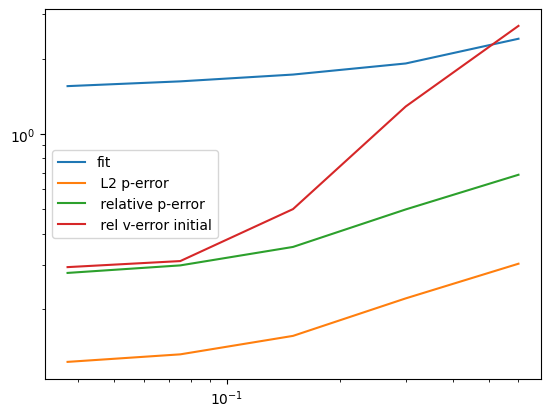

In [32]:
 import numpy as np
import matplotlib.pyplot as plt
hm = np.array( [0.6,0.3,0.15,0.075,0.0375])
 pressure_errors = 1.5*np.array( [0.20209034943866283,0.1469503899590114,0.10407885476068714,0.08782829969091777,0.08195020236874698 ]) # to be replaced
pressure_errors_1 = 1.5*np.array( [0.45791622127624976,0.332974668263161,0.23583212093610845,0.19901001257124998,0.1856908406631415 ]) # to be replaced
velocity_errors = 1.5*np.array( [1.8003567644937561,0.8581240142573686,0.33394619889505534,0.2070744108124048,0.19586592352567223 ]) # to be replaced

a = 1.0
b = 1.0
c = 1.0
alpha = 0.5
g=np.abs(np.log(hm))**(-1) 
f = a*np.abs(np.log(c*hm))**(-0.5) + b
print("f =", f)
plt.loglog(hm,f,label="fit")
plt.loglog(hm,pressure_errors,label=" L2 p-error ")
plt.loglog(hm,pressure_errors_1,label=" relative p-error ")
plt.loglog(hm,velocity_errors,label=" rel v-error initial")
# plt.loglog(g,f,label="fit")
# plt.loglog(g,pressure_errors,label="p-error")
#  plt.loglog(g,velocity_errors,label="v-error initial")
plt.legend()
plt.show()

In [33]:
# compute error 
t.Set(0)
print ("L2-error:", sqrt(Integrate( (u_sol[0]-uhx)**2 + (u_sol[1]-uhy)**2 , mesh)))

L2-error: 0.0029089225146177082


In [34]:
# compute error 
t.Set(tau*N)
print ("L2-error pressure:", sqrt(Integrate( (p_sol-p_primal)**2  , mesh)))

L2-error pressure: 0.27731401954422413


In [35]:
# compute error 
t.Set(0)
P_error= sqrt(Integrate( (p_sol-p_primal)**2  , mesh))
ref_error= sqrt(Integrate( (p_sol)**2  , mesh))
print ("L2-error pressure:", P_error/ ref_error )

L2-error pressure: 0.8080385968794898


In [36]:
import matplotlib.pyplot as plt 


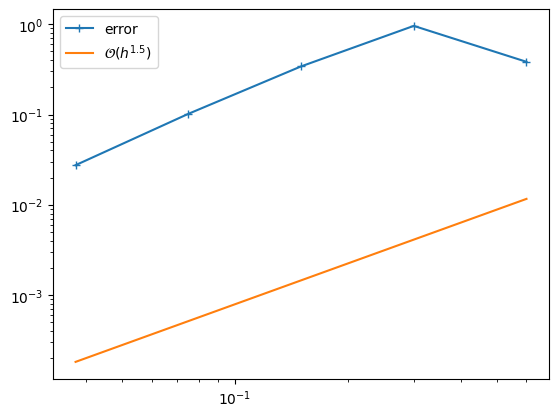

In [37]:
hnp = np.array(hm)
plt.loglog(hnp,l2_errors,label="error",marker= '+' ) 
plt.loglog(hnp,0.025*hnp**1.5,label="$\mathcal{O}(h^{1.5})$")
#plt.loglog(hnp,0.5*hnp**2,label="$\mathcal{O}(h^2)$")
plt.legend()
plt.show()

In [38]:
# conda = [ 1451.6151663808907,4549.610908080406,30027.705626469724 ]
# eoc = [ log(conda[i-1]/conda[i])/log(2) for i in range(1,len(conda))]

In [39]:
l2_errors_at_nodes = []
l2_errors_pressure_at_nodes = []
for n in range(0,N+1):
    t.Set(n*tau)
    uhx = gfu.components[0].components[N].components[0]
    uhy = gfu.components[0].components[N].components[1]
    p_primal = gfu.components[1].components[N-1]
    u_error= sqrt(Integrate( (u_sol[0]-uhx)**2 + (u_sol[1]-uhy)**2 , mesh))
    u_ref=sqrt(Integrate( (u_sol[0])**2 + (u_sol[1])**2 , mesh))
    p_error= sqrt(Integrate( (p_sol-p_primal)**2  , mesh))
    p_ref= sqrt(Integrate( (p_sol)**2  , mesh))
    l2_errors_at_nodes.append(u_error/u_ref)
    l2_errors_pressure_at_nodes.append(p_error/p_ref)
    print("L2 error velocity at time step {0} = {1}".format(n,l2_errors_at_nodes[-1] ))
    print("L2 error pressure at time step {0} = {1}".format(n,l2_errors_pressure_at_nodes[-1] ))
print("\n L2 error at time steps = ",l2_errors_at_nodes  )  
print("\n L2 error pressure at time steps = ",l2_errors_pressure_at_nodes  )  

L2 error velocity at time step 0 = 0.37400841218830955
L2 error pressure at time step 0 = 0.8080385968794898
L2 error velocity at time step 1 = 0.3836419742965527
L2 error pressure at time step 1 = 0.7674872609501381

 L2 error at time steps =  [0.37400841218830955, 0.3836419742965527]

 L2 error pressure at time steps =  [0.8080385968794898, 0.7674872609501381]


Initial time data all around

In [40]:
l2_errors_v = [0.37400841218830955,0.8009476685741628,0.3327507512028406,0.20665668262810288,0.1960735359364541]
l2_errors_p = [0.8080385968794898,0.34777118896966536,0.23585833422484329,0.19900989643125272,0.18534488544425648]
hm = [0.6,0.3,0.15,0.075,0.0375]
Ns = [1,2,4,8,16]
eoc_v = [ log(l2_errors_v[i-1]/l2_errors_v[i])/log(2) for i in range(1,len(l2_errors_v))]
eoc_p = [ log(l2_errors_p[i-1]/l2_errors_p[i])/log(2) for i in range(1,len(l2_errors_p))]

print(eoc_v)
print(eoc_p)

[-1.0986372649726388, 1.267266061409991, 0.6872059064094804, 0.07584118870899001]
[1.2162857887562954, 0.5602178373895458, 0.2450804050626287, 0.10262787055860834]


Final time data all around

In [41]:
l2_errors_v = [0.3836419742965527,0.959746346109117,0.34120706014206276,0.10168586650137905,0.027461821297623982]
l2_errors_p = [0.7674872609501381,0.24838278164038796,0.12253882919264307,0.0614838643962435,0.028806744283296208]
hm = [0.6,0.3,0.15,0.075,0.0375]
Ns = [1,2,4,8,16]
eoc_v = [ log(l2_errors_v[i-1]/l2_errors_v[i])/log(2) for i in range(1,len(l2_errors_v))]
eoc_p = [ log(l2_errors_p[i-1]/l2_errors_p[i])/log(2) for i in range(1,len(l2_errors_p))]

print(eoc_v)
print(eoc_p)

[-1.3228925881755331, 1.4920056638103882, 1.746528328335432, 1.8886199555289571]
[1.6275776375698086, 1.0193261945575767, 0.9949592225942067, 1.0938012270419382]
